In [1]:
import pandas as pd
import glob
import os



In [3]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

schema = StructType([
    StructField("name", StringType(), True),
    StructField("lat", DoubleType(), True),
    StructField("lon", DoubleType(), True),
    StructField("text", StringType(), True),
    StructField("date", StringType(), True),
    StructField("score", IntegerType(), True),
    StructField("keyword", StringType(), True),
    StructField("addr", StringType(), True),
    StructField("language", StringType(), True)
])

df = spark.read.csv('/home/ymusic7/metro_restaurants/combined.csv', header=False, schema=schema)


In [4]:
from pyspark.sql import functions as F
df_english = df.filter(F.col('language') == 'en')
df_english.show(5)


+--------------------+------------------+------------------+--------------------+-------------------+-----+-------------------+--------------------+--------+
|                name|               lat|               lon|                text|               date|score|            keyword|                addr|language|
+--------------------+------------------+------------------+--------------------+-------------------+-----+-------------------+--------------------+--------+
|        Sushi Avenue|33.864809699999995|       -84.0164532|This restaurant i...|2022-12-12 02:02:01|    5|japanese restaurant|2118 Scenic Hwy N...|      en|
|Volcano Steak & S...|        33.8837304|-84.73298129999999|5/5 because this ...|2024-07-06 22:24:10|    5|japanese restaurant|5750 Wendy Bagwel...|      en|
|        Sushi Avenue|33.864809699999995|       -84.0164532|Name has changed ...|2024-03-12 11:34:31|    5|japanese restaurant|2118 Scenic Hwy N...|      en|
|SAPPORO JAPANESE ...|        33.7214215|       -84.

In [4]:
# Count the number of reviews for each keyword
review_counts = df_english.groupBy("keyword").count()
review_counts.show()


+-------------------+------+
|            keyword| count|
+-------------------+------+
|japanese restaurant|211226|
| chinese restaurant|268833|
|         ON K2K 3M2|     1|
+-------------------+------+



In [6]:
df_filtered_keywords = df_english.filter(
    (F.col("keyword") == "chinese restaurant") | (F.col("keyword") == "japanese restaurant")
)
review_counts = df_filtered_keywords.groupBy("keyword").count()
review_counts.show()


+-------------------+------+
|            keyword| count|
+-------------------+------+
|japanese restaurant|211226|
| chinese restaurant|268833|
+-------------------+------+



In [7]:
# random sample to match to each kinds: 
# Minimum count between the two categories
min_count = review_counts.agg(F.min("count")).collect()[0][0]

# Sample to match the smaller count
df_chinese = df_filtered_keywords.filter(F.col("keyword") == "chinese restaurant").limit(min_count)
df_japanese = df_filtered_keywords.filter(F.col("keyword") == "japanese restaurant").limit(min_count)

# Combine datasets
df_balanced = df_chinese.union(df_japanese)

# Save balanced dataset
df_balanced.write.parquet("/home/ymusic7/metro_restaurants/balanced_reviews.parquet", mode="overwrite")


In [10]:
review_counts = df_balanced.groupBy("keyword").count()
review_counts.show()

+-------------------+------+
|            keyword| count|
+-------------------+------+
| chinese restaurant|211226|
|japanese restaurant|211226|
+-------------------+------+



In [11]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
import pyspark.sql.functions as F

# Load the balanced dataset
df_balanced = spark.read.parquet("/home/ymusic7/metro_restaurants/balanced_reviews.parquet")

# Convert text to lowercase
df_cleaned = df_balanced.withColumn('text', F.lower(F.col('text')))

# Tokenize the text
tokenizer = Tokenizer(inputCol='text', outputCol='words')
df_tokenized = tokenizer.transform(df_cleaned)

# Remove stopwords
stopwords = StopWordsRemover.loadDefaultStopWords("english")
remover = StopWordsRemover(inputCol='words', outputCol='filtered_words', stopWords=stopwords)
df_filtered = remover.transform(df_tokenized)

# View the cleaned and tokenized text
df_filtered.select('keyword', 'filtered_words').show(5, truncate=False)

# Save the preprocessed dataset for future use
df_filtered.write.parquet("/home/ymusic7/metro_restaurants/preprocessed_reviews.parquet", mode="overwrite")



+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|keyword            |filtered_words                                                                                                                                                                                                                                                    

Preprocessing completed and saved!


In [12]:
from pyspark.ml.feature import CountVectorizer

# Convert words into numerical features using CountVectorizer
vectorizer = CountVectorizer(inputCol='filtered_words', outputCol='features')
vectorized_model = vectorizer.fit(df_filtered)
df_vectorized = vectorized_model.transform(df_filtered)

# View the vectorized features
df_vectorized.select('keyword', 'features').show(5, truncate=False)



24/12/07 00:18:33 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/07 00:18:33 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|keyword            |features                                                                                                                                                                              

In [6]:
from pyspark.ml.feature import HashingTF, IDF

# Generate term frequency vectors
hashingTF = HashingTF(inputCol='filtered_words', outputCol='raw_features', numFeatures=5000)
df_tf = hashingTF.transform(df_filtered)

# Apply IDF to scale term frequency vectors
idf = IDF(inputCol='raw_features', outputCol='features')
idf_model = idf.fit(df_tf)
df_tfidf = idf_model.transform(df_tf)

# View the TF-IDF features
df_tfidf.select('features').show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
from pyspark.ml.clustering import KMeans

# Define K-Means model
kmeans = KMeans(featuresCol='features', predictionCol='cluster', k=6, seed=42)
model = kmeans.fit(df_tfidf)

# Assign clusters to reviews
df_clusters = model.transform(df_tfidf)

# View clustered data
df_clusters.select('text', 'cluster').show(5, truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|text                                                                                                                                                     

In [10]:
df_clusters.printSchema()


root
 |-- name: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- text: string (nullable = true)
 |-- date: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- keyword: string (nullable = true)
 |-- addr: string (nullable = true)
 |-- language: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- raw_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- cluster: integer (nullable = false)



In [11]:
df_clusters.select('keyword').distinct().show()



+-------------------+
|            keyword|
+-------------------+
|japanese restaurant|
| chinese restaurant|
|         ON K2K 3M2|
+-------------------+



In [ ]:
df_japanese = df_clusters.filter(F.col('keyword') == 'japanese restaurant')
df_chinese = df_clusters.filter(F.col('keyword') == 'chinese restaurant')



In [ ]:
import seaborn as sns
print(sns.__version__)



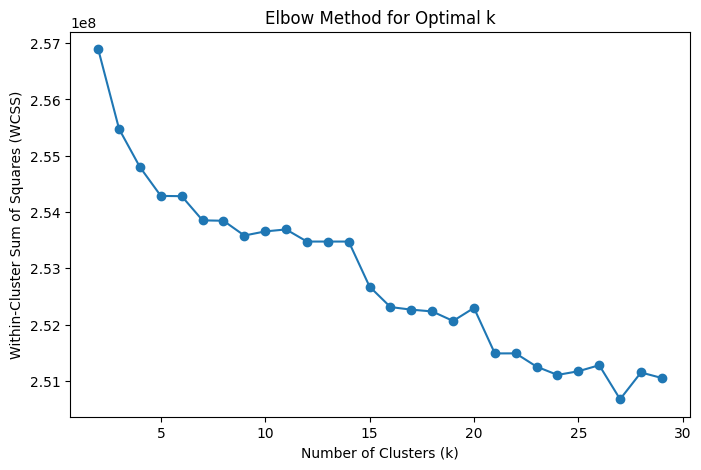

In [11]:
# k= 6 may not be suitable for this amount of reviews, using elbow method to find a better k value
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

wcss = []
for k in range(2, 30):  # Try different k values
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    model = kmeans.fit(df_tfidf)
    wcss.append(model.summary.trainingCost)

# Plot WCSS to find the "elbow"
plt.figure(figsize=(8, 5))
plt.plot(range(2, 30), wcss, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.show()


In [ ]:
#when i do the clustering training, should i separate Chinese and Japanese restaruant after tf idf 
#do cluserting separately or together cuz i think i did together and then seperate
#co-word?
# clustering based on TF-IDF, similar types of linguistic framing but no semantic detection (e.g., clusters that reflect affordability, quality of service, etc.).


In [7]:
# Separate datasets for Chinese and Japanese restaurants
df_chinese = df_tfidf.filter(F.col('keyword') == 'chinese restaurant')
df_japanese = df_tfidf.filter(F.col('keyword') == 'japanese restaurant')

In [8]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Run clustering for Chinese restaurants
kmeans_chinese = KMeans(featuresCol="features", k=12, seed=42)
model_chinese = kmeans_chinese.fit(df_chinese)
df_chinese_clusters = model_chinese.transform(df_chinese)

# Run clustering for Japanese restaurants
kmeans_japanese = KMeans(featuresCol="features", k=12, seed=42)
model_japanese = kmeans_japanese.fit(df_japanese)
df_japanese_clusters = model_japanese.transform(df_japanese)



In [9]:
# Count the number of reviews in each cluster for Chinese restaurants
df_chinese_clusters.groupBy("prediction").count().show()

# Count the number of reviews in each cluster for Japanese restaurants
df_japanese_clusters.groupBy("prediction").count().show()


+----------+------+
|prediction| count|
+----------+------+
|         1|   577|
|         6|   518|
|         3|  4730|
|         5| 36059|
|         9|  1260|
|         4| 15264|
|         8|  5013|
|         7|  7114|
|        10|   720|
|        11|  3968|
|         2| 33628|
|         0|159982|
+----------+------+



+----------+------+
|prediction| count|
+----------+------+
|         1| 45485|
|         6| 10385|
|         3| 11303|
|         5| 18604|
|         9|  3025|
|         7|  4635|
|        10|  1489|
|        11|   783|
|         0|115513|
|         4|     2|
|         8|     1|
|         2|     1|
+----------+------+



In [11]:
from pyspark.sql.functions import abs, mean, col, first, struct

# Calculate average score for each cluster
average_scores = df_chinese_clusters.groupBy("prediction").agg(mean("score").alias("avg_score"))

# Join clusters with their average scores
df_chinese_with_avg = df_chinese_clusters.join(average_scores, on="prediction")

# Find reviews closest to the average score for each cluster
representative_reviews_chinese = df_chinese_with_avg.withColumn(
    "score_diff", abs(col("score") - col("avg_score"))
).groupBy("prediction").agg(
    first(struct("score_diff", "text")).alias("closest_review")
).select(
    col("prediction"),
    col("closest_review.text").alias("representative_review")
)

# Show representative reviews
representative_reviews_chinese.show(truncate=False)



+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [12]:
from pyspark.sql.functions import abs, mean, col, first, struct, lit

# Calculate average score for each cluster
average_scores_japanese = df_japanese_clusters.groupBy("prediction").agg(mean("score").alias("avg_score"))

# Join clusters with their average scores
df_japanese_with_avg = df_japanese_clusters.join(average_scores_japanese, on="prediction")

# Find reviews closest to the average score for each cluster
representative_reviews_japanese = df_japanese_with_avg.withColumn(
    "score_diff", abs(col("score") - col("avg_score"))
).groupBy("prediction").agg(
    first(struct("score_diff", "text")).alias("closest_review")
).select(
    col("prediction"),
    col("closest_review.text").alias("representative_review")
)

# Show representative reviews for Japanese clusters
representative_reviews_japanese.show(truncate=False)


+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType
import numpy as np

# compute cosine similarity
def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return float(dot_product / (norm_v1 * norm_v2)) if norm_v1 != 0 and norm_v2 != 0 else 0.0

# Register the function as a UDF
cosine_similarity_udf = udf(lambda features, centroid: cosine_similarity(features.toArray(), centroid.toArray()), FloatType())

# Get cluster centroids
df_chinese_centroids = spark.createDataFrame(
    [(float(i), DenseVector(center)) for i, center in enumerate(model_chinese.clusterCenters())],
    ["prediction", "centroid"]
)

# Join clusters with their centroids
df_chinese_with_centroids = df_chinese_clusters.join(df_chinese_centroids, on="prediction")

# Compute cosine similarity for each review in Chinese clusters
df_chinese_with_similarity = df_chinese_with_centroids.withColumn(
    "cosine_similarity",
    cosine_similarity_udf(col("features"), col("centroid"))
)

# Get the most representative review for each cluster
representative_reviews_chinese = df_chinese_with_similarity.groupBy("prediction").agg(
    F.first(F.struct("cosine_similarity", "text")).alias("closest_review")
).select(
    col("prediction"),
    col("closest_review.text").alias("representative_review")
)

# Show representative reviews for Chinese clusters
representative_reviews_chinese.show(truncate=False)


+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType
import numpy as np

#  function to compute cosine similarity 
cosine_similarity_udf = udf(
    lambda features, centroid: cosine_similarity(features.toArray(), centroid.toArray()), 
    FloatType()
)

# Get cluster centroids for Japanese clusters
df_japanese_centroids = spark.createDataFrame(
    [(float(i), DenseVector(center)) for i, center in enumerate(model_japanese.clusterCenters())],
    ["prediction", "centroid"]
)

# Join clusters with their centroids for Japanese clusters
df_japanese_with_centroids = df_japanese_clusters.join(df_japanese_centroids, on="prediction")

# Compute cosine similarity for each review in Japanese clusters
df_japanese_with_similarity = df_japanese_with_centroids.withColumn(
    "cosine_similarity",
    cosine_similarity_udf(col("features"), col("centroid"))
)

# Get the most representative review for each cluster in Japanese clusters
representative_reviews_japanese = df_japanese_with_similarity.groupBy("prediction").agg(
    F.first(F.struct("cosine_similarity", "text")).alias("closest_review")
).select(
    col("prediction"),
    col("closest_review.text").alias("representative_review")
)

# Show representative reviews for Japanese clusters
representative_reviews_japanese.show(truncate=False)


+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
df_chinese_clusters.orderBy("text").show()


+--------------------+------------------+------------+--------------------+-------------------+-----+------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+----------+
|                name|               lat|         lon|                text|               date|score|           keyword|                addr|language|               words|      filtered_words|        raw_features|            features|prediction|
+--------------------+------------------+------------+--------------------+-------------------+-----+------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+----------+
|           Fresh Wok|        34.4250625|-117.3266261|! ! best dr.peppe...|2019-01-12 03:26:53|    4|chinese restaurant|15461 Main St #20...|      en|[!, !, best, dr.p...|[!, !, best, dr.p...|(5000,[55,106,157...|(5000,[55,106,157...|         0|
|Mandarin Lotus 

In [ ]:
df_chinese_with_similarity.filter(col("prediction") == 0).select("cosine_similarity", "text").orderBy("cosine_similarity", ascending=False).show()


In [12]:
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import col, concat_ws, lit

# Combine clustered data into one DataFrame with a column for cuisine type
df_combined_clusters = (
    df_chinese_clusters.select('prediction', 'filtered_words')
    .withColumn('cuisine', lit('chinese'))
    .union(
        df_japanese_clusters.select('prediction', 'filtered_words')
        .withColumn('cuisine', lit('japanese'))
    )
)

# Convert 'filtered_words' into a term frequency matrix using CountVectorizer
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")
vectorizer_model = vectorizer.fit(df_combined_clusters)
df_combined_vectorized = vectorizer_model.transform(df_combined_clusters)


In [13]:
# Run LDA
lda = LDA(k=12, maxIter=50, featuresCol="features", seed=42)  # `k=12` indicates the number of topics
lda_model = lda.fit(df_combined_vectorized)

# Describe topics
topics = lda_model.describeTopics()
topics.show(truncate=False)


24/12/05 14:08:47 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:08:52 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/05 14:08:53 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/05 14:08:55 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:08:55 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/12/05 14:08:55 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


24/12/05 14:08:59 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:00 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/05 14:09:02 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:04 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:05 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/05 14:09:07 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:08 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:09 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/05 14:09:11 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:12 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:13 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/05 14:09:15 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:16 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:18 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/05 14:09:19 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:21 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:22 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/05 14:09:23 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:25 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:26 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/05 14:09:28 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:29 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:31 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/05 14:09:32 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:34 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:35 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/05 14:09:37 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:38 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:40 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/05 14:09:41 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:43 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:44 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/05 14:09:45 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:47 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:48 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/05 14:09:49 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:51 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:52 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/05 14:09:53 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:55 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:56 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/05 14:09:58 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:09:59 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:10:01 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/05 14:10:02 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


24/12/05 14:10:04 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
[222.129s][warning][gc,alloc] Executor task launch worker for task 2.0 in stage 171.0 (TID 1241): Retried waiting for GCLocker too often allocating 3145730 words
24/12/05 14:10:04 ERROR Executor: Exception in task 2.0 in stage 171.0 (TID 1241)
java.lang.OutOfMemoryError: Java heap space
	at java.base/java.lang.reflect.Array.newInstance(Array.java:78)
	at java.base/java.io.ObjectInputStream.readArray(ObjectInputStream.java:2099)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1700)
	at java.base/java.io.ObjectInputStream.defaultReadFields(ObjectInputStream.java:2540)
	at java.base/java.io.ObjectInputStream.readSerialData(ObjectInputStream.java:2434)
	at java.base/java.io.ObjectInputStream.readOrdinaryObject(ObjectInputStream.java:2235)
	at java.base/java.io.ObjectInputStream.readObject0(ObjectInputStream.java:1712)
	at java.base/java.io.ObjectInputStream.defaultReadFields(Obj

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/software/python-anaconda-2022.05-el8-x86_64/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/scratch/local/jobs/26624175/ipykernel_3153989/4254524054.py", line 3, in <cell line: 3>
    lda_model = lda.fit(df_combined_vectorized)
  File "/software/spark-3.3.2-el8-x86_64/python/pyspark/ml/base.py", line 205, in fit
    return self._fit(dataset)
  File "/software/spark-3.3.2-el8-x86_64/python/pyspark/ml/wrapper.py", line 383, in _fit
    java_model = self._fit_java(dataset)
  File "/software/spark-3.3.2-el8-x86_64/python/pyspark/ml/wrapper.py", line 380, in _fit_java
    return self._java_obj.fit(dataset._jdf)
  File "/software/spark-3.3.2-el8-x86_64/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1321, in __call__
    return_value = get_return_value(
  File "/software/spark-3.3.2-el8-x86_64

ConnectionRefusedError: [Errno 111] Connection refused

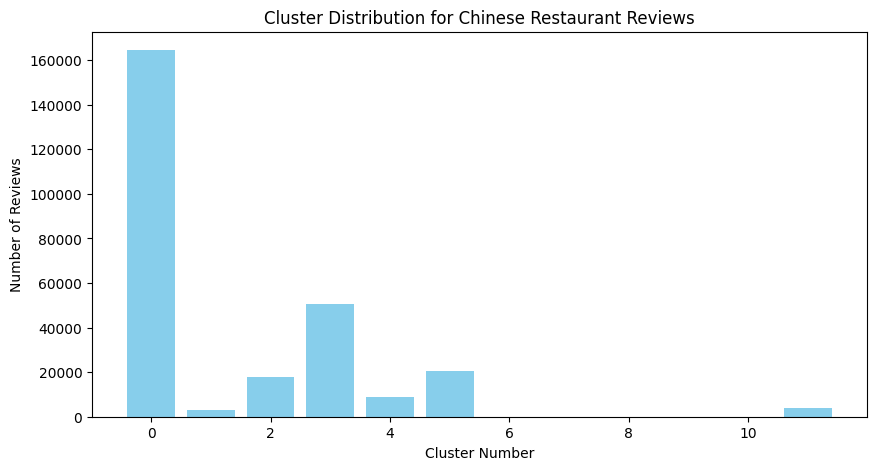

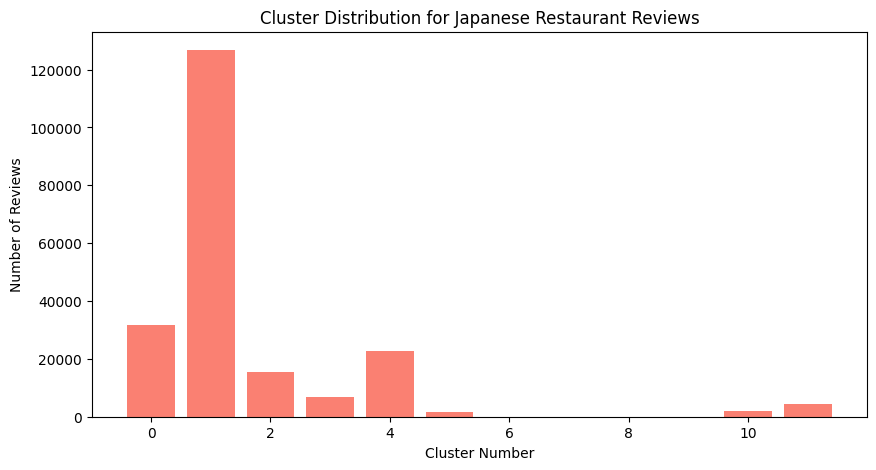

In [35]:
#visualize
import pandas as pd
import matplotlib.pyplot as plt

# Get cluster count data for Chinese restaurants
chinese_cluster_counts = df_chinese_clusters.groupBy("prediction").count().collect()
chinese_clusters_df = pd.DataFrame(chinese_cluster_counts, columns=["cluster", "count"])

# Plot the cluster distribution for Chinese restaurants
plt.figure(figsize=(10, 5))
plt.bar(chinese_clusters_df["cluster"], chinese_clusters_df["count"], color='skyblue')
plt.xlabel("Cluster Number")
plt.ylabel("Number of Reviews")
plt.title("Cluster Distribution for Chinese Restaurant Reviews")
plt.show()

# Get cluster count data for Japanese restaurants
japanese_cluster_counts = df_japanese_clusters.groupBy("prediction").count().collect()
japanese_clusters_df = pd.DataFrame(japanese_cluster_counts, columns=["cluster", "count"])

# Plot the cluster distribution for Japanese restaurants
plt.figure(figsize=(10, 5))
plt.bar(japanese_clusters_df["cluster"], japanese_clusters_df["count"], color='salmon')
plt.xlabel("Cluster Number")
plt.ylabel("Number of Reviews")
plt.title("Cluster Distribution for Japanese Restaurant Reviews")
plt.show()


In [ ]:
#LDA
# how consumer reviews reflect cultural contexts and how linguistic framing
# Import necessary modules for LDA
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
from pyspark.sql import functions as F

# load data and filter by cuisines (already clustered into 12 clusters)
df_chinese_clusters = df_chinese_clusters.select('prediction', 'filtered_words')
df_japanese_clusters = df_japanese_clusters.select('prediction', 'filtered_words')

# combine the clusters into a single DataFrame with a 'cuisine' column for differentiation
df_combined = df_chinese_clusters.withColumn('cuisine', F.lit('chinese'))
df_combined = df_combined.union(df_japanese_clusters.withColumn('cuisine', F.lit('japanese')))

# prepare the data for LDA
# convert filtered words into array<string> to be processed by CountVectorizer
df_combined = df_combined.withColumn('filtered_words_array', F.col('filtered_words'))

# Use CountVectorizer to convert the text data into a format suitable for LDA
vectorizer = CountVectorizer(inputCol='filtered_words_array', outputCol='features')
vectorizer_model = vectorizer.fit(df_combined)
df_combined_vectorized = vectorizer_model.transform(df_combined)

# Run LDA on the combined dataset to discover topics in the clusters
lda = LDA(k=12, maxIter=50, featuresCol='features', seed=42)
lda_model = lda.fit(df_combined_vectorized)

# Describe topics extracted by LDA
topics = lda_model.describeTopics()
print("LDA Topics:")
topics.show(truncate=False)

# Transform the data to assign each document (restaurant review) a topic
df_combined_lda = lda_model.transform(df_combined_vectorized)

# Show the results with topics for each review
df_combined_lda.select('cuisine', 'prediction', 'topicDistribution').show(truncate=False)

# Save the topic descriptions and transformed data for further analysis
topics.write.csv('/home/ymusic7/metro_restaurants/lda_topics.csv', header=True)
df_combined_lda.write.csv('/home/ymusic7/metro_restaurants/lda_transformed.csv', header=True)




# Shutdown Spark session to release resources
#spark.stop()


In [ ]:
# Check the data type of column `filtered_words_str`
df_combined.printSchema()


In [35]:
# Save the Series as a JSON file
topics.to_json('/home/ymusic7/metro_restaurants/lda_topics_series.json', orient='index')


In [32]:
print(type(topics))



<class 'pandas.core.series.Series'>


In [ ]:
from pyspark.sql.functions import expr

# Find the topic with the highest probability for each review
df_combined_lda = df_combined_lda.withColumn(
    "topic", expr("array_position(topicDistribution, array_max(topicDistribution)) - 1")
)

# group by topic to get a representative review (e.g., first review per topic)
representative_reviews = df_combined_lda.groupBy("topic").agg(
    F.first("filtered_words").alias("representative_review"),
    F.first("cuisine").alias("cuisine")
)

# show the representative reviews
representative_reviews.show(truncate=False)
# result not printed but it's the same 


In [33]:
# Convert the Series to a DataFrame if necessary
if isinstance(topics, pd.Series):
    topics = topics.to_frame()

print(topics.columns)  # Check the new DataFrame columns


Index(['Topic'], dtype='object')


In [21]:
# Get the vocabulary from the CountVectorizer model
vocabulary = vectorizer_model.vocabulary

# Iterate over all topics to get top terms for each topic
topics_df = topics.collect()
topic_terms = {}

for topic in topics_df:
    topic_id = topic['topic']
    term_indices = topic['termIndices']
    top_terms = [vocabulary[index] for index in term_indices]
    topic_terms[topic_id] = top_terms
    print(f"Top terms for topic {topic_id}: {top_terms}")



Top terms for topic 0: ['food', '', 'time', 'good', 'like', 'always', 'chinese', 'really', 'chicken', 'place']
Top terms for topic 1: ['ordered', 'sushi', 'food', 'service', 'time', 'order', 'great', 'like', 'best', 'really']
Top terms for topic 2: ['food', '', 'service', 'sushi', 'y', 'de', 'great', 'place', 'la', 'like']
Top terms for topic 3: ['food', '', 'good', 'great', 'food.', 'service', 'sushi', 'get', 'chinese', 'even']
Top terms for topic 4: ['food', 'good', 'place', 'bon', '', 'service', 'one', 'like', 'time', 'sushi']
Top terms for topic 5: ['food', 'great', 'good', 'place', 'sushi', 'really', 'always', 'back', '', 'go']
Top terms for topic 6: ['great', '', 'food', 'sushi', 'place', 'best', 'service', 'chinese', 'chicken', 'rice']
Top terms for topic 7: ['food', 'place', 'sushi', 'chinese', 'best', 'always', 'one', 'get', 'really', 'service']
Top terms for topic 8: ['food', '', 'great', 'good', 'place', 'sushi', 'service', 'chinese', 'chicken', 'like']
Top terms for topic 9

In [22]:
#average topic weight for each cuisine to determine which topics are more prevalent in reviews for Chinese and Japanese restaurants.
from pyspark.sql import types as T

# define a UDF to extract the topic weight for each topic
def get_topic_weight(topic_dist, index):
    return topic_dist[index]

# Register UDFs to get each topic weight as a separate column
for i in range(12):
    udf_func = F.udf(lambda x: float(x[i]), T.DoubleType())
    df_combined_lda = df_combined_lda.withColumn(f'topic_{i}_weight', udf_func(F.col('topicDistribution')))

# Calculate average topic weights by cuisine
average_topic_weights = df_combined_lda.groupBy('cuisine').avg(*[f'topic_{i}_weight' for i in range(12)])

average_topic_weights.show(truncate=False)


+--------+---------------------+--------------------+--------------------+--------------------+---------------------+---------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|cuisine |avg(topic_0_weight)  |avg(topic_1_weight) |avg(topic_2_weight) |avg(topic_3_weight) |avg(topic_4_weight)  |avg(topic_5_weight)  |avg(topic_6_weight) |avg(topic_7_weight) |avg(topic_8_weight)|avg(topic_9_weight) |avg(topic_10_weight)|avg(topic_11_weight)|
+--------+---------------------+--------------------+--------------------+--------------------+---------------------+---------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|chinese |0.005384955112219467 |0.004939626136634131|0.008779211059619069|0.005519930525128038|0.0057247220250029535|0.005166600385369806 |0.005277058193858216|0.004909189864254653|0.9371712791218489 |0.00

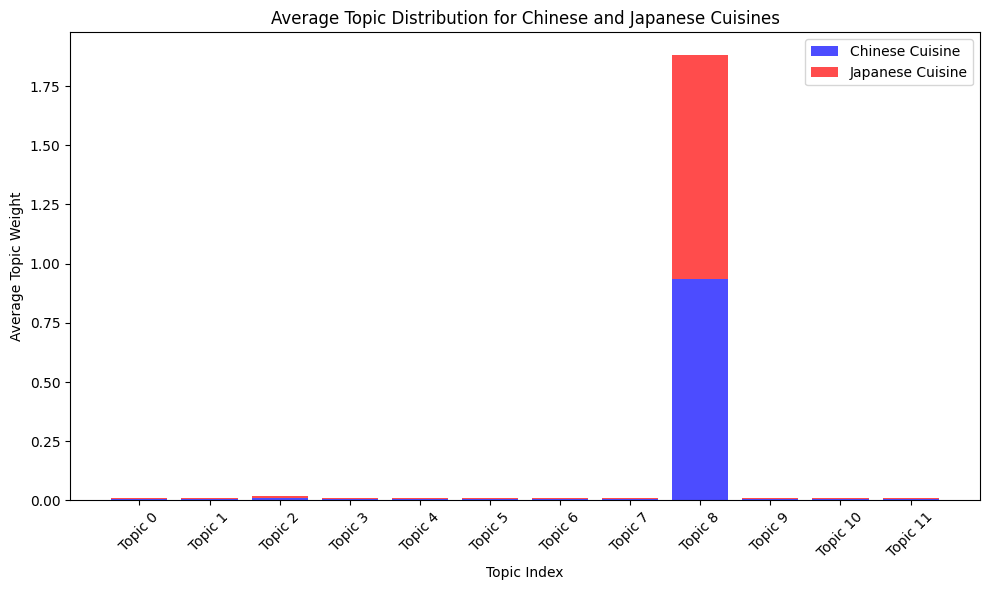

In [24]:
#plot to see
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data for plotting, HARD CODING....
data = {
    'Topic': [f'Topic {i}' for i in range(12)],
    'Chinese_Cuisine': [0.00538, 0.00494, 0.00878, 0.00552, 0.00572, 0.00517, 0.00528, 0.00491, 0.93717, 0.00531, 0.00504, 0.00669],
    'Japanese_Cuisine': [0.00443, 0.00426, 0.00851, 0.00456, 0.00498, 0.00440, 0.00457, 0.00418, 0.94582, 0.00432, 0.00425, 0.00567]
}


df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))

# Topics as the x axis
topics = df['Topic']

# Plot bars for Chinese and Japanese cuisines
ax.bar(topics, df['Chinese_Cuisine'], color='blue', label='Chinese Cuisine', alpha=0.7)
ax.bar(topics, df['Japanese_Cuisine'], bottom=df['Chinese_Cuisine'], color='red', label='Japanese Cuisine', alpha=0.7)

ax.set_xlabel('Topic Index')
ax.set_ylabel('Average Topic Weight')
ax.set_title('Average Topic Distribution for Chinese and Japanese Cuisines')
ax.legend()


plt.xticks(rotation=45)
plt.tight_layout()


plt.show()



In [40]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load the JSON file into a DataFrame
with open('/home/ymusic7/metro_restaurants/lda_topics_series.json', 'r') as json_file:
    json_data = json.load(json_file)

# Assuming the JSON data is a list of dictionaries
topics_df = pd.DataFrame(json_data)

# Check the structure of the DataFrame
print(topics_df.head())


             0        1        2        3        4        5        6        7  \
Topic  Topic 0  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7   

             8        9        10        11  
Topic  Topic 8  Topic 9  Topic 10  Topic 11  


In [49]:

import pandas as pd

topics_df = pd.DataFrame(data)
print(topics_df.head())


     Topic  Chinese_Cuisine  Japanese_Cuisine
0  Topic 0          0.00538           0.00443
1  Topic 1          0.00494           0.00426
2  Topic 2          0.00878           0.00851
3  Topic 3          0.00552           0.00456
4  Topic 4          0.00572           0.00498
